## Домашняя работа №3

#### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
import os

from statsmodels.tsa.arima_model import ARIMA
from random import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data_energy = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data_energy.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_energy = data_energy.resample('M').mean()
data_energy.drop(columns=['dayofyear','weekofyear','dayofweek', 'hour', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'],inplace=True)

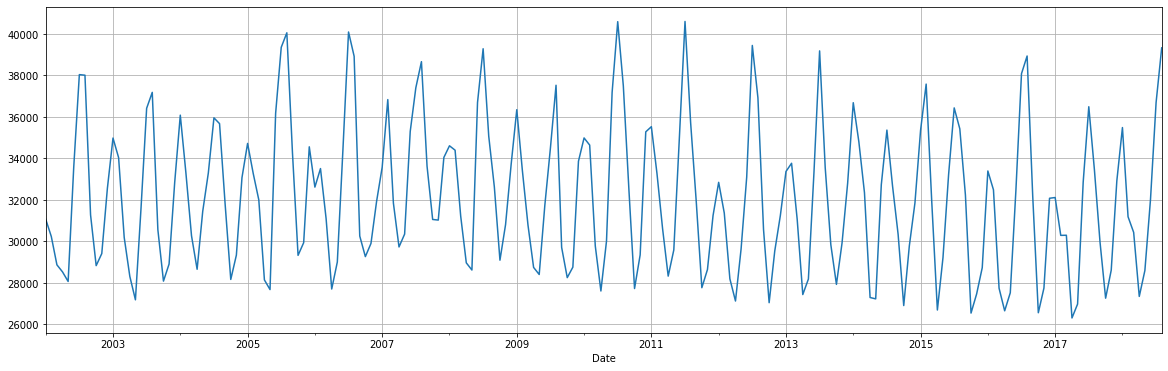

In [4]:
plt.figure(figsize =(20,6))
data_energy['PJME_MW'].plot()
plt.grid()
plt.show();

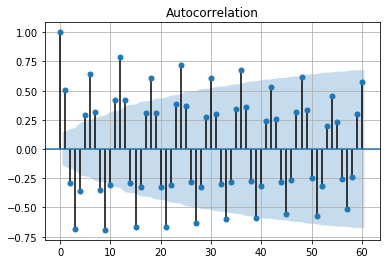

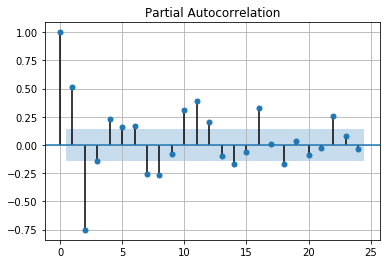

In [5]:
sm.graphics.tsa.plot_acf(data_energy['PJME_MW'].values, lags=60)
plt.grid()
sm.graphics.tsa.plot_pacf(data_energy['PJME_MW'].values, lags=24)
plt.grid()
plt.show();

#### 2. Подберите параметры модели SARIMAX для этого ряда.

In [6]:
%%time

# Определим p, d и q 
q = 6
p = 6
d = 1
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 12 месяцев
qs = 2
ps = 1
ds = 1
seasonal_pdq = [ps, ds, qs , 12] 

# в качестве тестовых данных используем 12 последних месяца ряда
mod = sm.tsa.statespace.SARIMAX(data_energy['PJME_MW'].values[:-12],
                                order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[6, 1, 6]x[1, 1, 2, 12] - AIC:2548.6340117313457
Wall time: 32.2 s


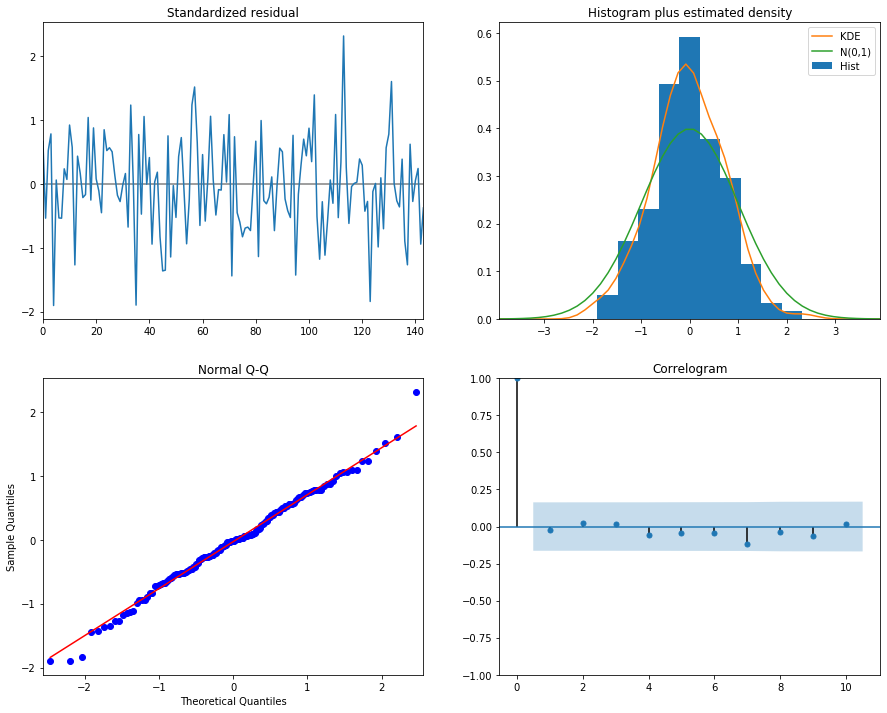

In [7]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

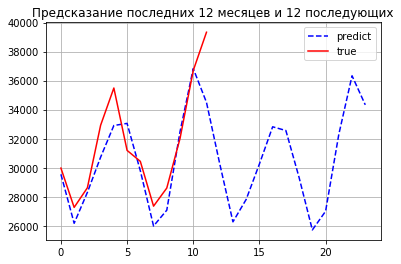

In [8]:
pred = results.forecast(24)    #делаем предсказание на 3 точки от текущего конца ряда

#Отобразим истинный значения 

plt.plot(pred,'--b', label='predict')
plt.plot(data_energy['PJME_MW'].values[-12:],'-r',label='true')
plt.title('Предсказание последних 12 месяцев и 12 последующих')
plt.legend()
plt.grid()
plt.show();

#### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

В сравнение с недельной моделью сезонность стала более выраженной и месячная модель стала лучше пронозировать.